In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
from transformers import (
    AutoProcessor, 
    AutoModelForImageTextToText,
    AutoImageProcessor,
    AutoModel,
    TextStreamer
)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
merged_model_path = '/kaggle/input/smollm/pytorch/default/1/content/smolvlm_merged_final'
text_model = AutoModelForImageTextToText.from_pretrained(
    merged_model_path,
    torch_dtype=torch.float16,
).to(device)
text_model.eval()
text_processor = AutoProcessor.from_pretrained(merged_model_path)

dino_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dino_encoder = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
dino_encoder.eval()

In [ ]:
class MultiTaskDINO(nn.Module):
    def __init__(self, encoder, num_regression_outputs=6, num_classes=9):
        super().__init__()
        self.encoder = encoder
        self.feature_dim = encoder.config.hidden_size
        
        self.quality_regression_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_regression_outputs)
        )
        
        self.scene_classification_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        outputs = self.encoder(x)
        pooled_output = outputs.pooler_output
        regression_preds = self.quality_regression_head(pooled_output)
        classification_preds = self.scene_classification_head(pooled_output)
        return regression_preds, classification_preds

quality_model = MultiTaskDINO(dino_encoder).to(device)
quality_model.load_state_dict(torch.load("/kaggle/input/dinov2/pytorch/default/1/multi_task_dino_best.pth"))
quality_model.eval()

In [51]:
attribute_ranges = {
    'Image Score (Overall)': (0, 100),
    'Brightness': (0, 100),
    'Colorfulness': (0, 100),
    'Contrast': (0, 100),
    'Noisiness': (0, 100),
    'Sharpness': (0, 100)
}

scene_labels = [
    'Animal', 'Cityscape', 'Human', 'Indoor scene', 
    'Landscape', 'Night scene', 'Plant', 'Still-life', 'Others'
]

In [65]:
def download_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None

def generate_description(model, processor, image):
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Can you describe the quality of this image in detail?"}
        ]
    }]
    
    inputs = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True,
            num_beams=1,
            top_k=50,
            top_p=0.95,
            temperature=1.1,
            num_return_sequences=1
        )
    
    full_response = processor.decode(outputs[0], skip_special_tokens=True)
    clean_response = full_response.split("Assistant:")[-1].strip()
    clean_response = clean_response.replace("User:", "").strip()
    
    return clean_response

def assess_quality(image):
    inputs = dino_processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        reg_preds, cls_preds = quality_model(inputs.pixel_values)
    
    attributes = {
        'Image Score (Overall)': reg_preds[0][0].item(),
        'Brightness': reg_preds[0][1].item(),
        'Colorfulness': reg_preds[0][2].item(),
        'Contrast': reg_preds[0][3].item(),
        'Noisiness': reg_preds[0][4].item(),
        'Sharpness': reg_preds[0][5].item()
    }
    
    for attr, value in attributes.items():
        min_val, max_val = attribute_ranges[attr]
        attributes[attr] = value * (max_val - min_val) + min_val
    
    scene_probs = torch.sigmoid(cls_preds[0]).cpu().numpy()
    scene_results = {label: prob for label, prob in zip(scene_labels, scene_probs)}
    
    return attributes, scene_results

In [53]:
def plot_results(attributes, scene_probs):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(attributes)))
    ax[0].bar(attributes.keys(), attributes.values(), color=colors)
    ax[0].set_title('Image Quality Assessment', fontsize=14)
    ax[0].set_ylabel('Score (0-100)', fontsize=12)
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].grid(axis='y', alpha=0.3)
    
    scene_labels_sorted = sorted(scene_probs, key=scene_probs.get, reverse=True)
    scene_probs_sorted = [scene_probs[label] for label in scene_labels_sorted]
    colors = plt.cm.plasma(np.linspace(0, 1, len(scene_labels)))
    ax[1].barh(scene_labels_sorted, scene_probs_sorted, color=colors)
    ax[1].set_title('Scene Category Probabilities', fontsize=14)
    ax[1].set_xlabel('Probability', fontsize=12)
    ax[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    return fig

def analyze_image(image_url):
    image = download_image(image_url)
    if image is None:
        return
    
    description = generate_description(text_model, text_processor, image)
    attributes, scene_probs = assess_quality(image)
    
    plt.figure(figsize=(16, 12))
    plt.suptitle("Complete Image Quality Analysis", fontsize=16, y=1.02)
    
    gs = plt.GridSpec(3, 2, height_ratios=[3, 1, 1])
    
    ax1 = plt.subplot(gs[0, 0])
    ax1.imshow(image)
    ax1.set_title("Input Image", fontsize=14)
    ax1.axis('off')
    
    ax2 = plt.subplot(gs[0, 1])
    colors = plt.cm.viridis(np.linspace(0, 1, len(attributes)))
    ax2.bar(attributes.keys(), attributes.values(), color=colors)
    ax2.set_title('Quality Assessment', fontsize=14)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    ax3 = plt.subplot(gs[1, :])
    scene_labels_sorted = sorted(scene_probs, key=scene_probs.get, reverse=True)
    scene_probs_sorted = [scene_probs[label] for label in scene_labels_sorted]
    colors = plt.cm.plasma(np.linspace(0, 1, len(scene_labels)))
    ax3.barh(scene_labels_sorted, scene_probs_sorted, color=colors)
    ax3.set_title('Scene Categories', fontsize=14)
    ax3.set_xlim(0, 1)
    ax3.grid(axis='x', alpha=0.3)
    
    ax4 = plt.subplot(gs[2, :])
    ax4.text(0.01, 0.5, description, 
            ha='left', va='center', wrap=True,
            fontsize=12, bbox=dict(facecolor='whitesmoke', alpha=0.5))
    ax4.set_title('Quality Description', fontsize=14)
    ax4.axis('off')
    
    plt.tight_layout()

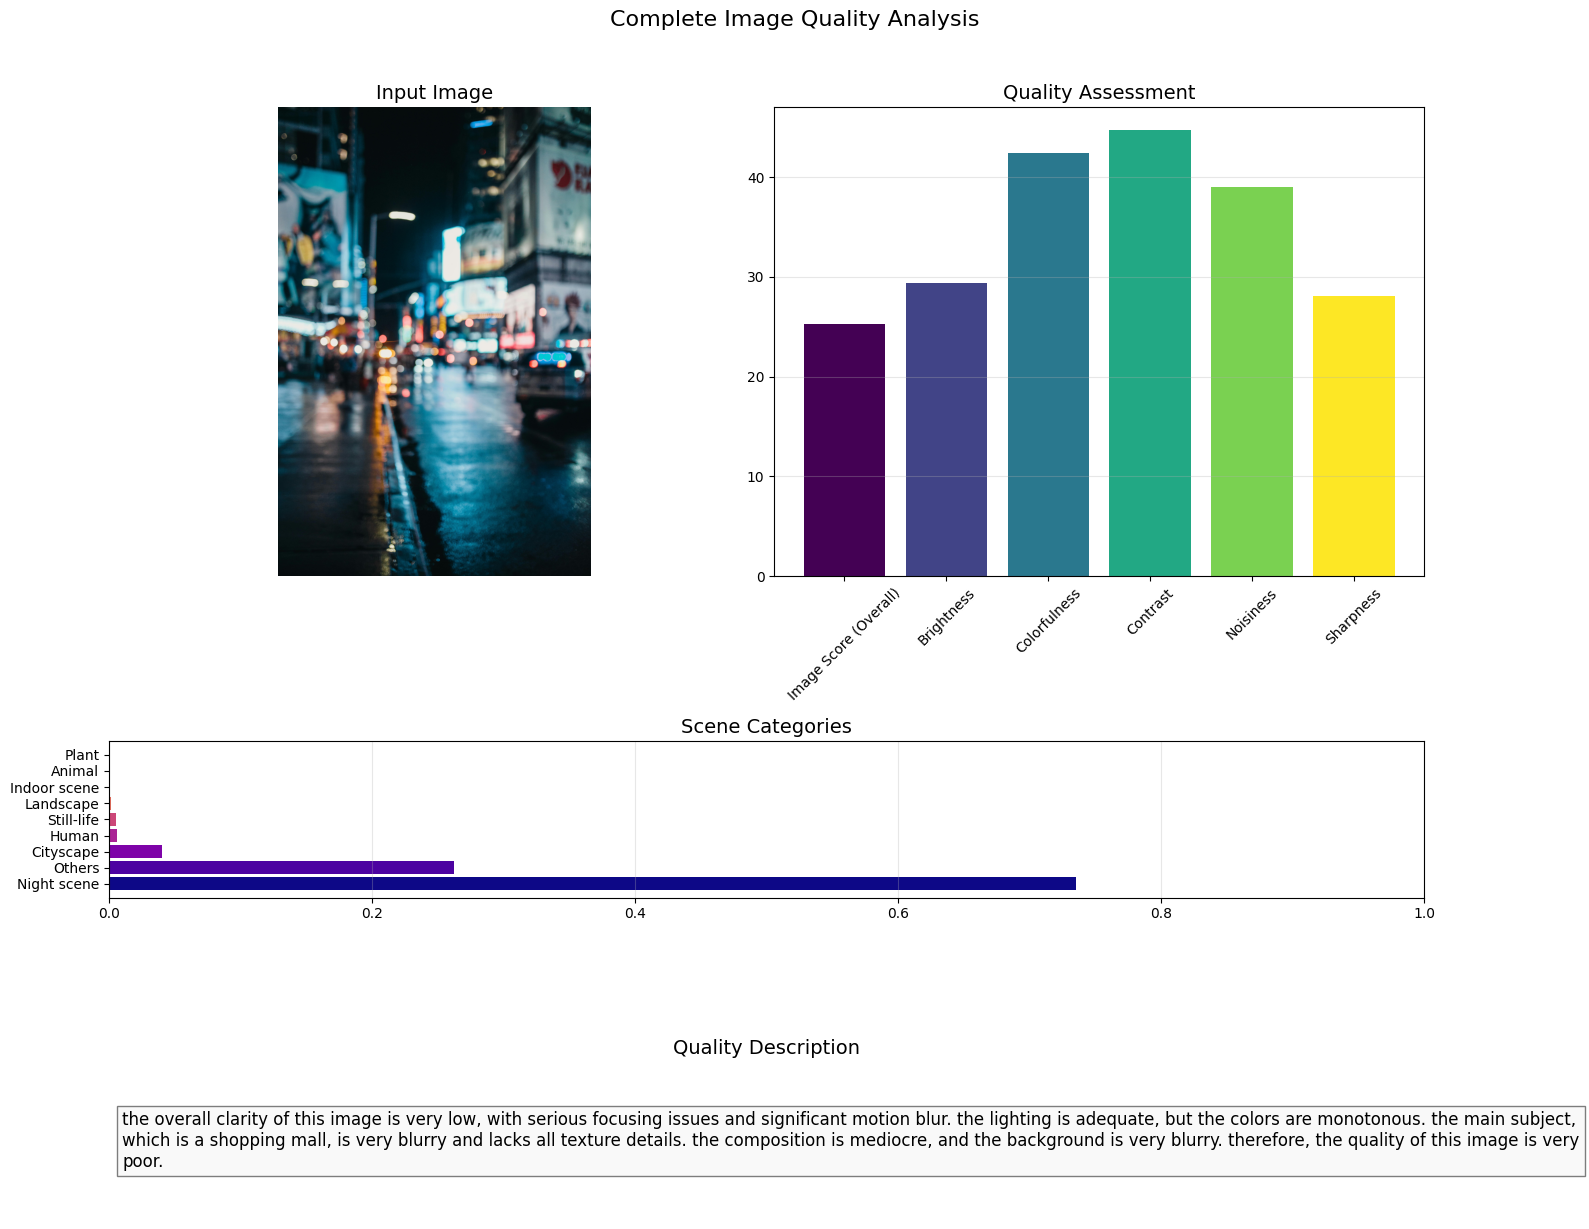

In [54]:
if __name__ == "__main__":
    image_url = "https://images.pexels.com/photos/1668928/pexels-photo-1668928.jpeg?cs=srgb&dl=pexels-guiirossi-1668928.jpg&fm=jpg"
    analyze_image(image_url)

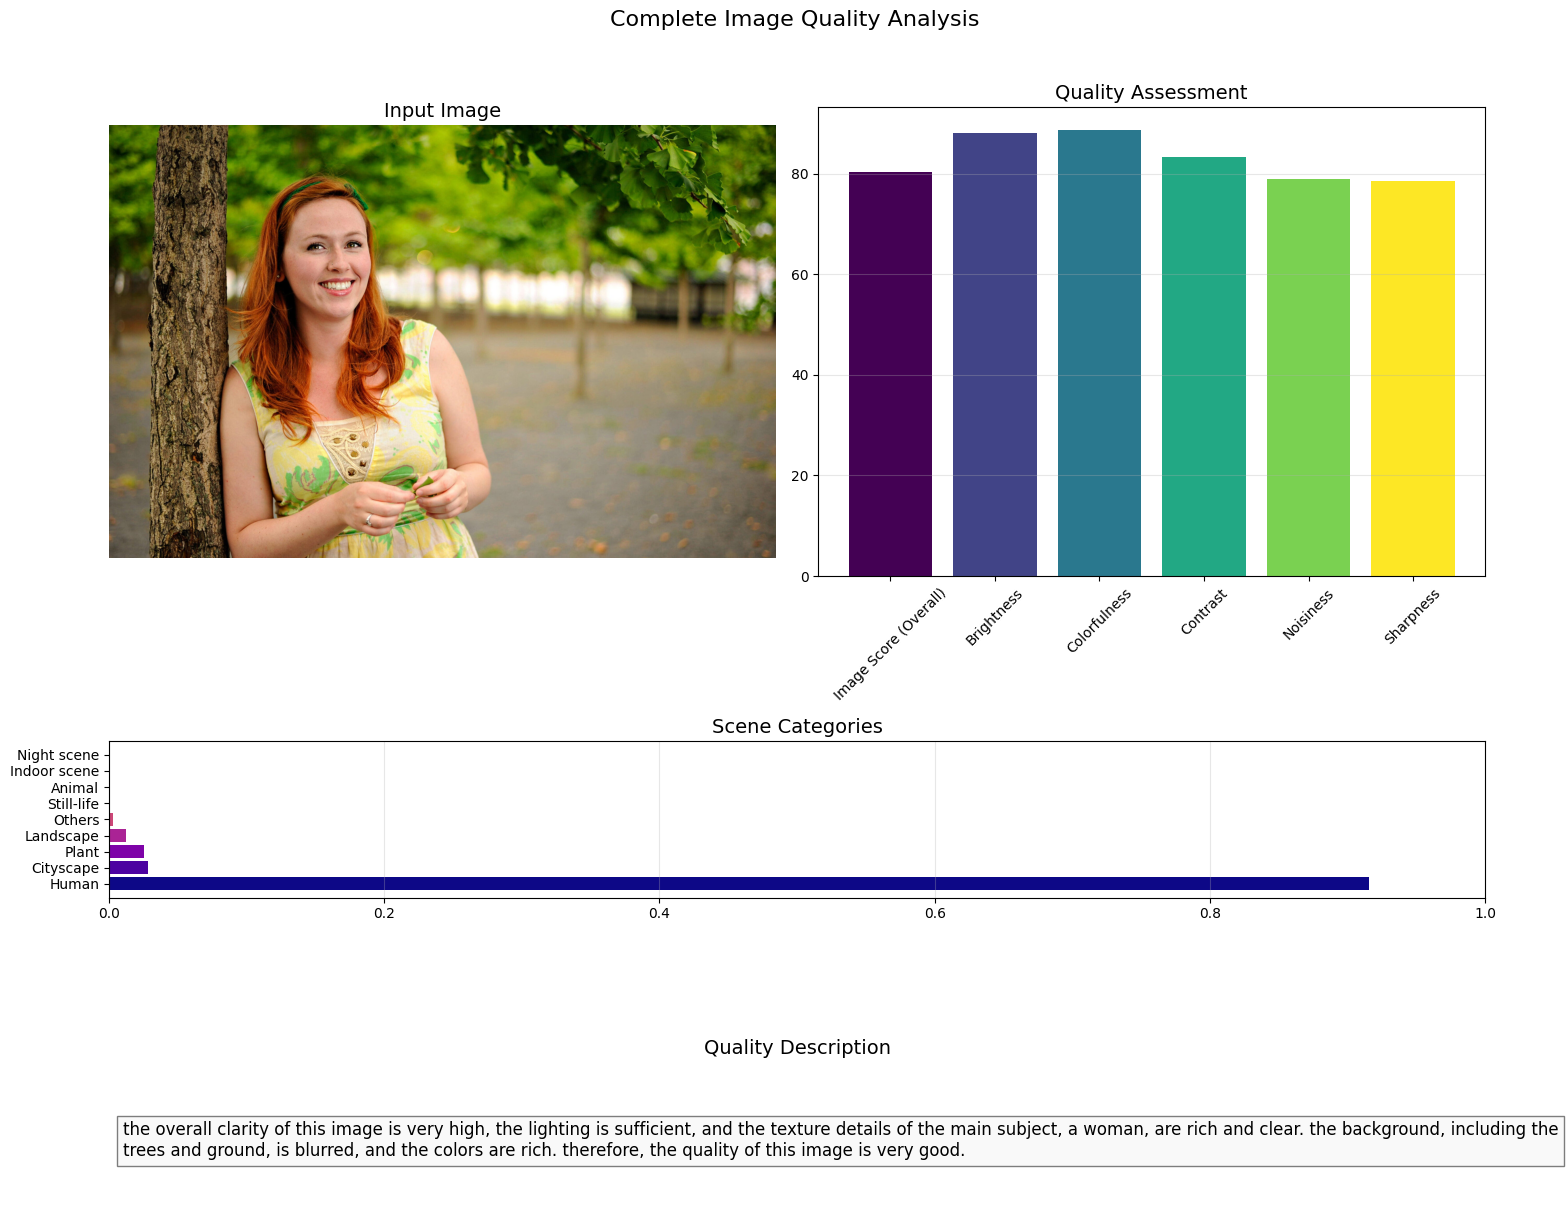

In [55]:
img_url = 'https://www.popphoto.com/uploads/2022/06/14/20110710Rachel-scaled.jpeg?auto=webp'
analyze_image(img_url)

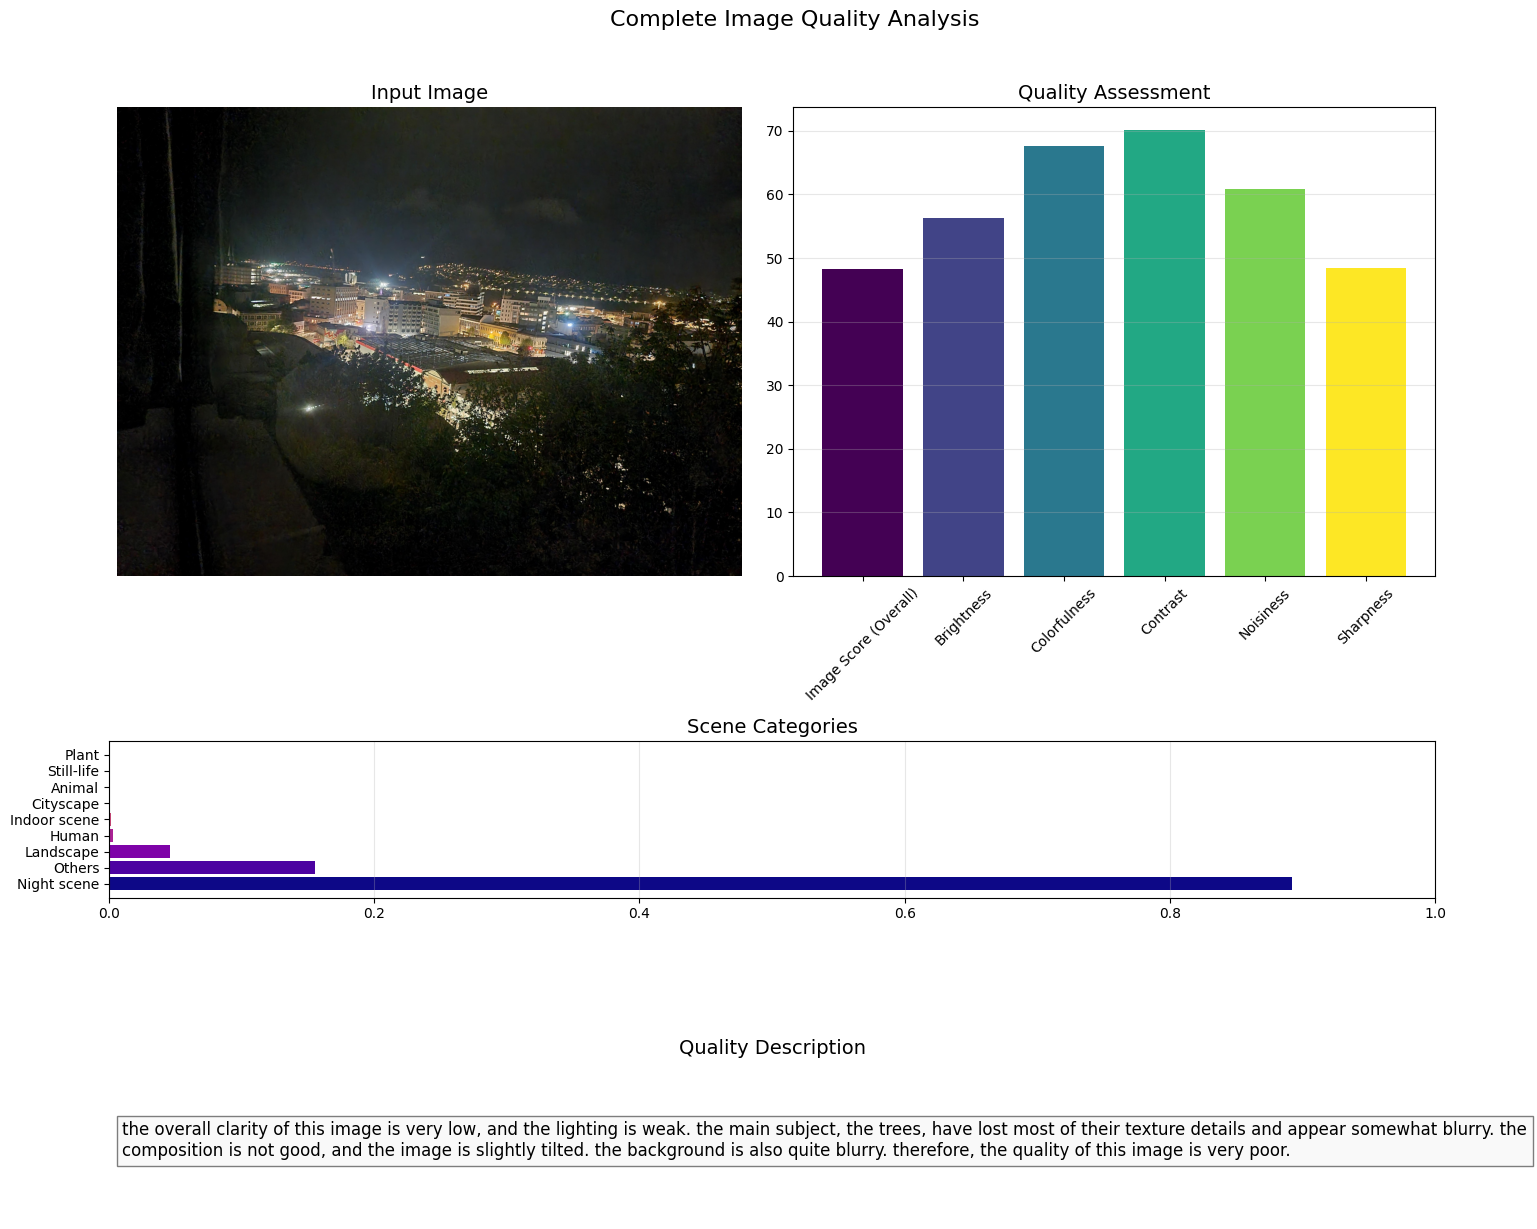

In [59]:
url = 'https://i.redd.it/1iinf823wjvb1.jpg'
analyze_image(url)

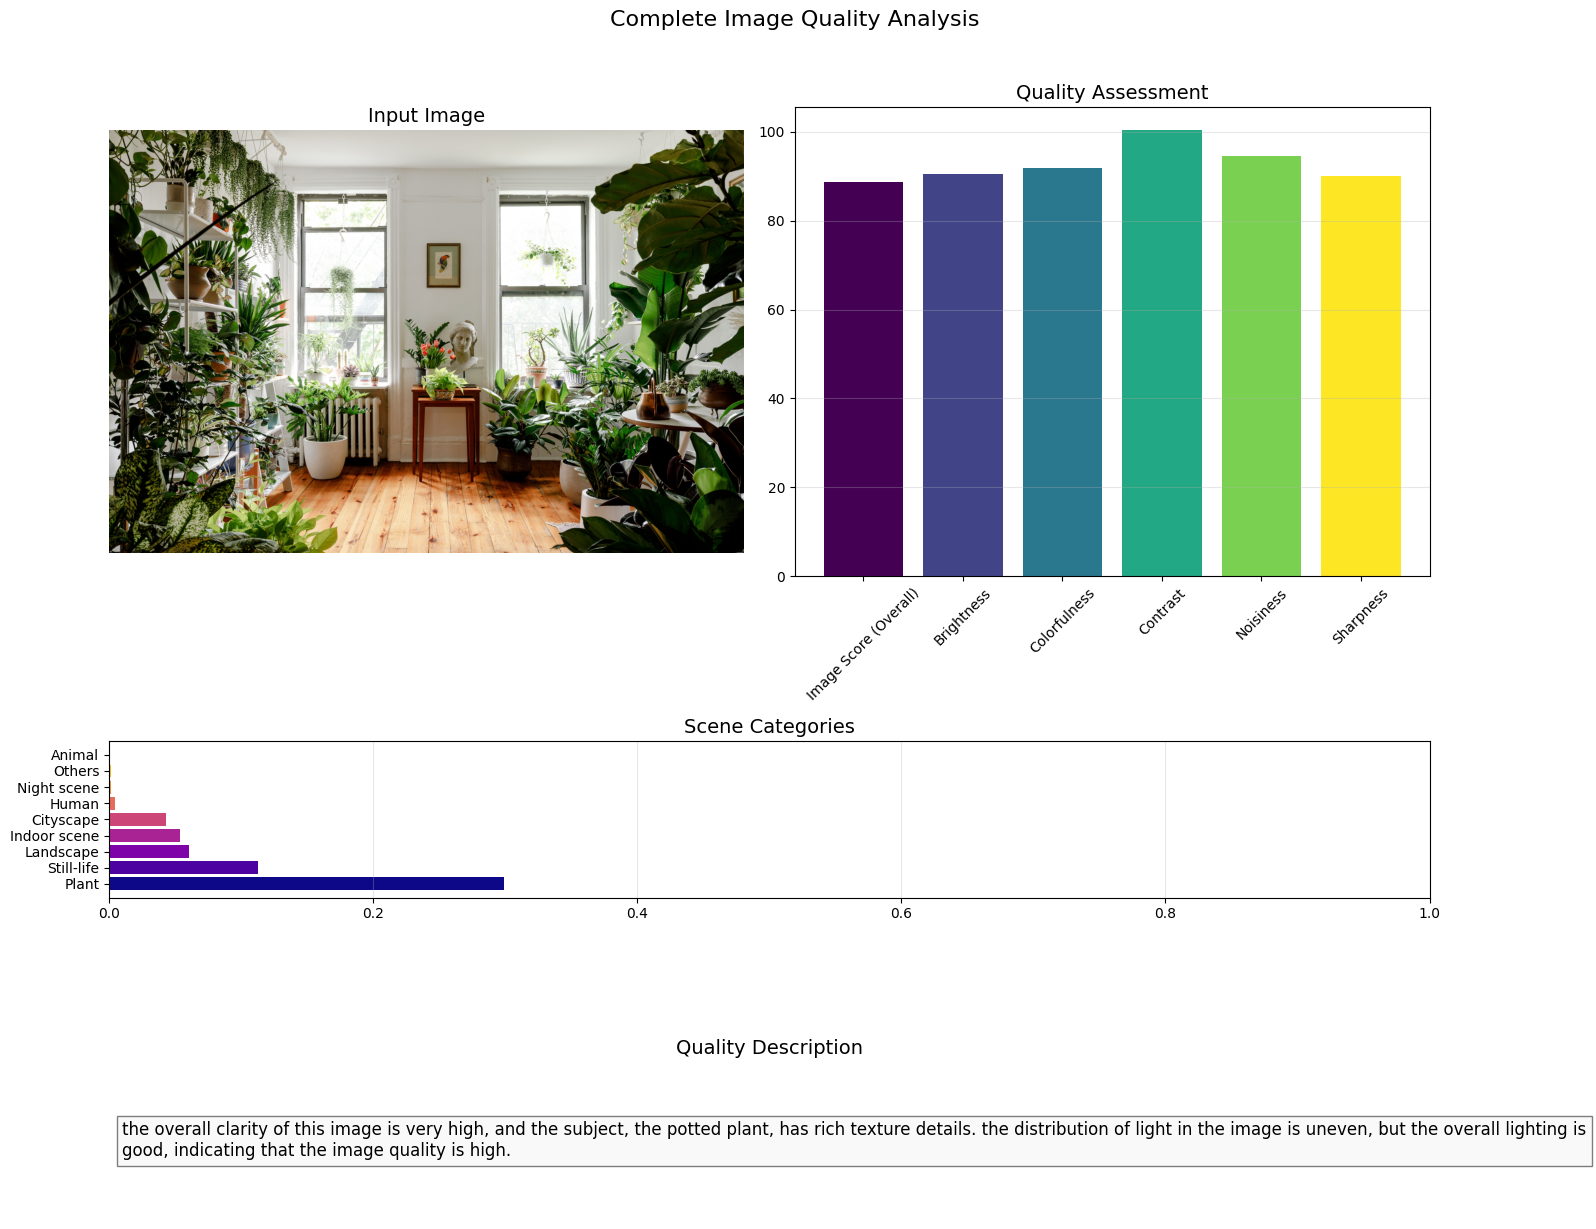

In [67]:
url = 'https://media.architecturaldigest.com/photos/5dcde00380598800086215f6/master/pass/Osofsky_Oct19-5.jpg'
analyze_image(url)